In [18]:
import pandas as pd
import seaborn as sns
import statsmodels.tsa.stattools as ts
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

#Setting seaborn style
sns.set(style='white', palette='bright')

In [19]:
def create_dataframe(data_csv):

    # Create a pandas DataFrame containing the spread data
    spreads = pd.read_csv(data_csv, index_col="Date")
    # Convert index to a Datetime object
    spreads.index = pd.to_datetime(spreads.index)
    return spreads


def augmented_dickey_fuller(spreads):
    
    # Output the results of the Augmented Dickey-Fuller test for Google
    # with a lag order value of 1
    adf = ts.adfuller(spreads['Container A'], 1)
    print(adf)


if __name__ == "__main__":
    data_csv = (r'C:\Users\MADYMA\Desktop\Python Files\absspreadstest.csv')

    spreads_df = create_dataframe(data_csv)
    spreads_adf = augmented_dickey_fuller(spreads_df)

(-2.1658531741852416, 0.21887131097442358, 1, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, 3094.4997684418904)


In [20]:
# Data is most likely not stationary. Let's see what type of properties it exhibits using the Hurst exponents.

def hurst(ts):
    
    # Create the range of lag values
    lags = range(2, 200)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

# Assuming you have run the above code to obtain 'spreads'
print("Hurst(Container A):  %s" % hurst(spreads_df['Container A'].values))



Hurst(GBM):   0.5112482569687773
Hurst(MR):    5.5605395727087106e-05
Hurst(TR):    0.9593104417308664
Hurst(Container A):  0.09743023379500369


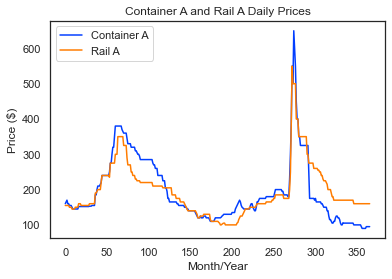

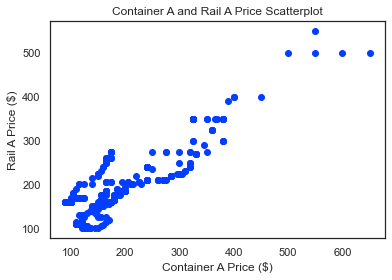

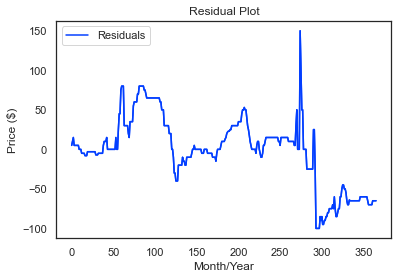

(-1.8530874848138732, 0.354441568065721, 3, 362, {'1%': -3.448544133483233, '5%': -2.8695574079525565, '10%': -2.5710411593052713}, 2755.7158235980182)


In [21]:
# So the data looks to be mean reverting. Not many data points though.

def plot_price_series(df, ts1, ts2):
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

def plot_residuals(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label='Residuals', color='b')

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()

    plt.plot(df["res"])
    plt.show()

if __name__ == "__main__":

    twos = pd.read_csv(r'C:\Users\MADYMA\Desktop\Python Files\absspreadstest.csv')

    df = pd.DataFrame(index=twos.index)
    df["Container A"] = twos["Container A"]
    df["Rail A"] = twos["Rail A"]

    # Plot the two time series
    plot_price_series(df, "Container A", "Rail A")

    # Display a scatter plot of the two time series
    plot_scatter_series(df, "Container A", "Rail A")

    # Calculate optimal hedge ratio "beta"
    res = sm.OLS(endog=df["Container A"], exog=df["Rail A"]).fit()   

    # Calculate the residuals of the linear combination
    df["res"] = df["Container A"] - 1.00*df["Rail A"]

    # Plot the residuals
    plot_residuals(df)

    # Calculate and output the CADF test on the residuals
    cadf = ts.adfuller(df["res"])
    print(cadf)

In [22]:
# We cannot reject the null hypothesis. There isn't a cointegrating relationship.

Rail A    1.002149
dtype: float64